# TP4 : Descente de gradient et débruitage d'une image en niveaux de gris

Le but de ce TP est de comprendre comment mettre au point un **modèle variationnel** de débruitage, c'est-à-dire ramener la problématique de débruiter une image à un problème de minimisation. L'idée essentielle étant de trouver une quantité (une fonction $J$ qui prend une image en argument, à valeurs dans $\mathbb{R}$) qui permette de distinguer une image comportant du bruit d'une image "propre" : 

$$
J ( \text{image propre} ) << J(\text{image bruitée}) \: .
$$

On utilisera ensuite l'algorithme de **descente de gradient** afin de résoudre le problème de minimisation posé. 


On commence par charger une image couleurs de taille 256 par 256 pixels ici, on récupère ici un `np.ndarray`, les deux premières dimensions ($256$, $256$) sont le nombre de pixels dans la hauteur et dans la largeur de l'image. La dernière dimension permet de stocker les 3 canaux couleurs R, V, B et éventuellement un quatrième canal "alpha" (transparence, perçu lorsque l'image est superposée à une autre image) qu'on laissera ici de côté.

<class 'numpy.ndarray'> (256, 256, 4)


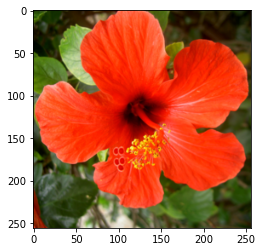

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.image as mpimg

name = 'hibiscus256.bmp'
img0 = mpimg.imread(name)
plt.imshow(img0)

n,N,a = img0.shape # n : nb de lignes et N : nb de colonnes
print(type(img0), img0.shape)

On se place au niveau de la ligne de pixel $50$ et on représente la variation de chacun des trois canaux de couleurs, notés `Sr`, `Sv` et `Sb`, le long de cette ligne. On les renormalise par $255$ afin de ramener le tracé entre $0$ et $1$. La moyenne de ces trois canaux nous donnera le niveau de gris, c'est le `np.array` de taille `N = 256` noté `S` par la suite.

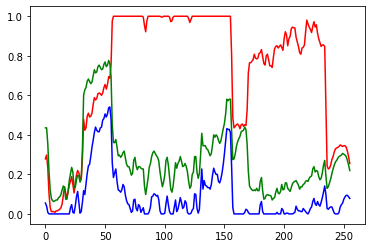

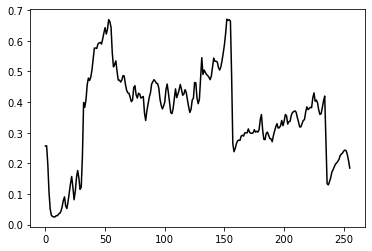

In [2]:
Sr = img0[50,:,0]/255
Sv = img0[50,:,1]/255
Sb = img0[50,:,2]/255
S = (Sr + Sv + Sb)/3
plt.figure()
plt.plot(Sr, 'red')
plt.plot(Sv, 'green')
plt.plot(Sb, 'blue')
plt.figure()
plt.plot(S, 'black')

On va maintenant "bruiter" le signal $S$ : on considère un échantillon de $N$ variables aléatoires iid selon la loi normale $\mathcal{N} (0,\sigma^2)$ centrée de variance $\sigma^2$, on prendra ici $\sigma = 0.1$, on rappelle que le signal $S$ varie entre $0$ et $1$. On obtient une réalisation de cet échantillon par un appel à la fonction `np.random.normal(0,0.1,N)`, on vient ajouter cette réalisation à `S`, on appellera `Snoise` le signal bruité ainsi créé.

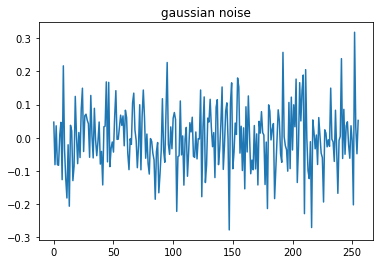

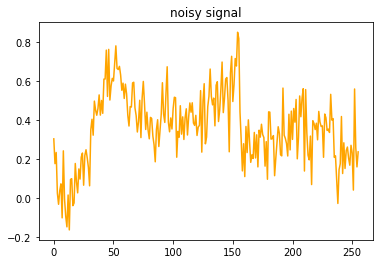

In [3]:
noise = np.random.normal(0, 0.1, N)
Snoise = S + noise

plt.figure()
plt.title('gaussian noise')
plt.plot(noise)
plt.figure()
plt.title('noisy signal')
plt.plot(Snoise, 'orange')

## Exercice 1.- Un modèle variationnel pour débruiter un signal 1D

On se donne $v : [0,1] \rightarrow \mathbb{R}$ qu'on suppose être une version bruitée (penser à $S_{noise}$) de $u : [0,1] \rightarrow \mathbb{R}$ (penser à $S$) qu'on ne connaît pas et qu'on souhaiterait "retrouver". Pour cela, on va essayer de différencier (de façon quantitative) un signal bruité d'un signal non bruité : on observe que le signal bruité oscille beaucoup, sa dérivée (si le signal $v$ est dérivable) est grande en valeur absolue et par exemple pour $q \geq 1$,
$$
\| v^\prime \|_{q} = \left( \int_{[0,1]} | v^\prime |^q \right)^\frac{1}{q} \quad \text{sera plus grand pour } v \text{ que pour } u \: . 
$$
Du point de vue du signal discret, on peut remplacer la dérivée par le taux de variation entre deux valeurs successives : supposons qu'on connaît
$$
V = \left[ v(x_0) , v(x_1), \ldots, v(x_{N-1}) \right] \in \mathbb{R}^N \quad \text{avec} \quad x_k = k h , \quad h = \frac{1}{N-1}
$$
on peut définir
$$
\delta V = \left[ v(x_1) - v(x_0), v(x_2) - v(x_1) , \ldots, v(x_{N-1}) - v(x_{N-2}) \right] = \left[ V_1 - V_0, V_2 - V_1, \ldots, V_{N-1} - V_{N-2} \right] \in \mathbb{R}^{N-1}
$$
ou encore
$$
\delta_h V = \frac{\delta V}{h} = \left[ \frac{v(x_1) - v(x_0)}{h}, \frac{v(x_2) - v(x_1)}{h} , \ldots, \frac{v(x_{N-1}) - v(x_{N-2})}{h} \right] \: .
$$
De même que pour le signal continu, on peut alors définir
$$
\left\| \delta_h V \right\|_q = \frac{1}{h} \| \delta V \|_q = \frac{1}{h} \left( \sum_{k=0}^{N-2} | (\delta V)_k |^q \right)^\frac{1}{q} \quad \text{où} \quad \| \cdot \|_q \text{ désigne la norme } q \text{ dans } \mathbb{R}^{N-1} \: .
$$

1. Reprendre les vecteurs `S` et `Snoise` et représenter sur une même figure $\| \delta S \|_q$ et $\| \delta S_{noise} \|_q$ en fonction de $q$, pour $q \in $ `np.arange(1,8,0.2)` par exemple.

*Indication : on pourra définir une fonction `delta` qui prend en argument un `np.array V` et renvoie le `np.array` $\delta V$ et utiliser ensuite la fonction `np.linalg.norm`.*

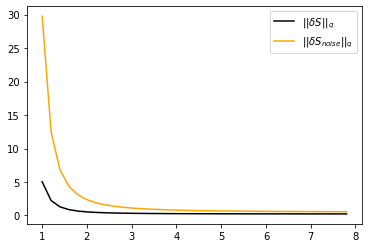

In [4]:
def delta(V):
    return V[1:] - V[:-1]

qq = np.arange(1,8,0.2)
qqsize = qq.size
JS = np.zeros(qqsize)
JSnoise = np.zeros(qqsize)
for i,q in enumerate(qq):
    JS[i] = np.linalg.norm(delta(S),q)
    JSnoise[i] = np.linalg.norm(delta(Snoise),q)  
    
plt.figure()
plt.plot(qq, JS, color='black', label = u'$ || \delta S ||_q$')
plt.plot(qq, JSnoise, color='orange', label = u'$|| \delta S_{noise} ||_q$')
plt.legend()

2. On observe que pour $1 \leq q \leq 2$ au moins, comme attendu, $\| \delta S \|_q << \| \delta S_{noise} \|_q$. Afin de confirmer cette observation, on réalise $m$ fois cette expérience : pour cela on appelle $m$ fois la fonction `np.random.normal(0, 0.1, N)` et on obtient $m$ versions bruitées de `S` : 
$S_{noise}^{(1)}, \ldots, S_{noise}^{(m)}$.
Compléter le script ci-dessous afin de représenter sur une deuxième figure
$$
\min_{1 \leq k \leq m} \| \delta S_{noise}^{(k)} \|_q \quad \text{et} \quad \max_{1 \leq k \leq m} \| \delta S_{noise}^{(k)} \|_q 
$$
en fonction de $q$ pour les valeurs de $q \in $ `np.arange(1,8,0.2)` précédentes.

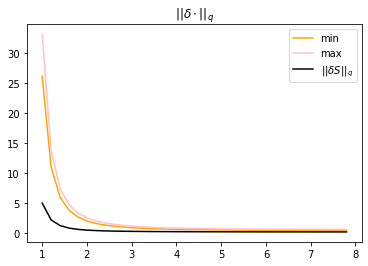

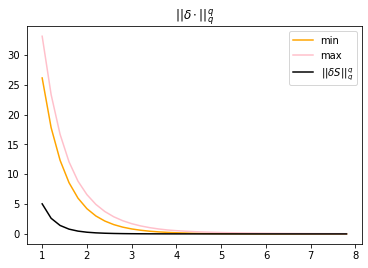

In [5]:
m = 100
qqsize = qq.size
E = np.zeros((qqsize,m))
F = np.zeros((qqsize,m))
for k in range(m):
    noise = np.random.normal(0, 0.1, N) 
    Snoise = S + noise
    for j in range(qqsize):
        q = qq[j]
        E[j,k] = np.linalg.norm(delta(Snoise),q)
        F[j,k] = np.linalg.norm(delta(Snoise),q)**q
        
plt.figure()
plt.plot(qq, np.amin(E,axis=1), label = 'min', color = 'orange')
plt.plot(qq, np.amax(E,axis=1), label = 'max', color = 'pink')
plt.plot(qq, JS, color='black', label = u'$ || \delta S ||_q$')
plt.title(r'$|| \delta \cdot ||_q$')
plt.legend()

plt.figure()
plt.plot(qq, np.amin(F,axis=1), label = 'min', color = 'orange')
plt.plot(qq, np.amax(F,axis=1), label = 'max', color = 'pink')
plt.plot(qq, JS**qq, label = u'$ || \delta S ||_q^q$', color='black')
plt.title(r'$|| \delta \cdot ||_q^q$')
plt.legend()

3. Cela confirme que pour $1 \leq q \leq 2$, pour tout $k = 1, \ldots, m$, $\| \delta S \|_q << \| \delta S_{noise}^{(k)} \|_q$. Modifier votre script (ci-dessus) afin de représenter sur une deuxième figure $\| \delta \cdot \|_q^q$ à la place de $\| \delta \cdot \|_q$, i.e. représenter
$$
\min_{1 \leq k \leq m} \| \delta S_{noise}^{(k)} \|_q^q \quad \text{et} \quad \max_{1 \leq k \leq m} \| \delta S_{noise}^{(k)} \|_q^q 
$$
en fonction de $q$ pour les valeurs de $q \in $ `np.arange(1,8,0.2)` précédentes.


On peut finalement considérer $\| \delta \cdot \|_q^q$ afin de distinguer un signal bruité $S_{noise}$ du signal non bruité $S$. Afin d'essayer de retrouver $S$,
on va donc chercher à retrouver $V$ proche de $S_{noise}$ en minimisant
$$
J_q (V) = \| \delta V \|_q^q = \sum_{k=1}^{N-1} | V_k - V_{k-1} |^q \: .
$$
Il reste à traduire "$S$ proche de $S_{noise}$", pour cela on va ajouter un terme pénalisant l'écart en norme ${\rm L}^2$ entre $V$ et $S_{noise}$, généralement appelé *terme d'attache aux données* :
$$
\| V - S_{noise} \|_2^2 = \sum_{k=0}^{N-1} |V_k - S_{noise, k} |^ 2 \: .
$$

4. Représenter sur une troisième figure
$$
 \| S_{noise}^{(k)} - S \|_2^2 
$$
cette fois-ci en fonction de $k$ pour $1 \leq k \leq m$ pour $3$ niveaux de bruit différents $\sigma \in \{ 0.05, 0.1, 0.2\}$. *On pourra compléter/modifier le script ci-dessous.*

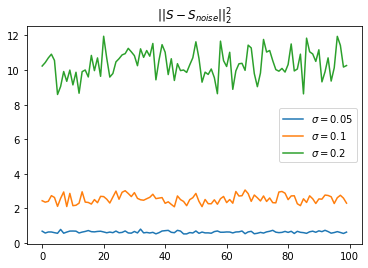

In [6]:
plt.figure()
m = 100
G = np.zeros((m,3))
for ind,sigma in enumerate([0.05, 0.1, 0.2]):
    for k in range(m):
        noise = np.random.normal(0, sigma, N) 
        Snoise = S + noise
        G[k,ind] = np.linalg.norm(S - Snoise,2)**2
    plt.plot(np.arange(m), G[:,ind], label = u'$\sigma = $'+str(sigma))
plt.title(r'$|| S - S_{noise} ||_2^2$')
plt.legend()

On aboutit au problème de minimisation

$$ \tag{$P$}
\min_{V \in \mathbb{R}^N} E_q(V) \quad \text{avec} \quad E_q(V) = \frac{1}{2} \| V - S_{noise} \|_2^2 + \frac{\lambda}{2} J_q (V) \quad \text{pour} \quad \lambda > 0 \text{ fixé.}
$$

et on espère que si $V$ est un minimiseur, $V$ sera proche du signal initial $S$. Le paramètre $\lambda$ adapte le poids relatif de $J$ vis-à-vis du "terme d'attache aux données" peut être choisi sur une sélection d'images bruitées artificiellement par exemple ou on peut tester différentes valeurs de $\lambda$.

## Exercice 2.- Etude du problème de minimisation 

1. Soit $S_0 \in \mathbb{R}^N$ fixé et $\lambda > 0$. Montrer que pour tout $q \in [1, + \infty[$,

$$
E_q : \mathbb{R}^N \rightarrow \mathbb{R}, \quad V \mapsto \frac{1}{2}\| V - S_0 \|_2^2 + \frac{\lambda}{2} J_q (V) 
$$

est convexe (en particulier continue - dimension finie) et coercive. *(Dans cette section, $S_0$ est le signal observé, le $S_{noise}$ de la section précédente.)*

**Convexité.-**
- $V \mapsto \| V - S_0 \|_2$ est composée d'une fonction affine et de $\| \cdot \|_2$ qui est convexe grâce à l'inégalité triangulaire, leur composée est convexe. On ajoute ensuite une composition par $t \mapsto t^2$ qui est convexe croissante sur $\mathbb{R}_+$, leur composée $V \mapsto \| V - S_0 \|_2^2$ est bien convexe. En utilisant le cas d'égalité dans l'inégalité triangulaire pour $\| \dot \|_2$, on a même qu'elle est strictement convexe. 
- $J_q$ est strictement convexe pour les même raisons : $\delta $ est affine, $\| \cdot \|_q$ est convexe et $t \mapsto t^q$ est convexe croissante sur $\mathbb{R}_+$.
- La somme d'une fonction convexe et d'une fonction strictement convexe est strictement convexe de sorte que $E_q$ est strictement convexe.

**Coercivité.-**
$$
E_q(V) \geq \frac{1}{2}\| V - S_0 \|_2^2 \geq \frac{1}{2}\| V \|_2^2 - \left\langle V , S_0 \right\rangle \underbrace{\geq}_{C.S.} \| V \|_2^2 \left( \frac{1}{2} - \frac{\|S_0\|_2}{\|V\|_2} \right) \xrightarrow[\|V\|_2 \to +\infty]{} +\infty
$$

Comme de plus $E_q$ est continue (directement par sa définition ou comme conséquence de sa convexité, le problème de minimisation $(P)$ admet une unique solution $V_\ast \in \mathbb{R}^N$.

2. On fixe dans un premier temps $q = 2$. Justifier que $E = E_2$ est de classe ${\rm C}^\infty$ et calculer son gradient puis sa hessienne.

On rappelle que la norme euclidienne au carré $f : V \mapsto \| V \|_2^2$ sur $\mathbb{R}^N$ est de classe ${\rm C}^\infty$ et au point $V \in \mathbb{R}^N$,

$$
\text{son gradient est donné par } \nabla f(V) = 2 V \quad \text{et sa Hessienne par } \nabla^2 f(V) = 2 I_N \: .
$$

Ainsi $E$ est de classe ${\rm C}^\infty$ comme composition de $f$ avec des applications linéaires. De plus, pour $V \in \mathbb{R}^N$,

$$
\nabla E(V) = V - S_0 + \frac{\lambda}{2} \nabla J(V) \: .
$$
Soit maintenant $k \in \{0, 1, \ldots, N-1 \}$, on rappelle que $\displaystyle J(V) = \sum_{i=1}^{N-1} |V_i - V_{i-1} |^2$ de sorte que $V_k$ apparait dans la somme pour $i = k$ et $i = k+1$, on en déduit que pour $0< k < N-1$,
$$
\frac{1}{2} \partial_k J(V) = (V_k - V_{k-1}) + (V_k - V_{k+1}) = 2 V_k - V_{k-1} - V_{k+1} \quad \text{et} \quad \frac{1}{2}\partial_0 J(V) = V_0 - V_1 \quad \text{et} \quad \frac{1}{2}\partial_{N-1} J(V) = V_{N-1} - V_{N-2} \: .
$$
L'application $V \mapsto \nabla J(V)$ est linéaire et sa hessienne est alors la matrice $A$ définie à la question suivante.
La Hessienne de $E$ au point $V \in \mathbb{R}^N$ est alors $\displaystyle \nabla^2 E(V) = I_N + \lambda A$.

3. On définit la matrice symétrique $A \in {\rm M}_N(\mathbb{R})$ par
$$
A = \left[ \begin{array}{ccccccc}
1  & -1 & 0    &    & \cdots &    & 0 \\
-1 &  2 & -1   & 0  &        &    & 0 \\
0  & -1 & 2    & -1 & 0      &    & 0 \\
\vdots &  \ddots  & \ddots  & \ddots  & \ddots  &    & \vdots \\
\vdots & & \ddots    & \ddots  & \ddots  & \ddots    & \vdots \\
0  &  &      0 & -1 &      2 & -1 & 0\\
0  &    &      &  0 &     -1 &  2 & -1\\
0  &  & \cdots &    & 0      & -1 & 1
\end{array} \right] \: .
$$
Vérifier numériquement, pour $N=256$ par exemple, que $A$ a toutes ses valeurs propres entre $0$ et $4$ ? Qu'en est-il alors de la matrice $I_N + \lambda A$, (pour $\lambda > 0$).

In [7]:
def HessA(K):
    A = 2*np.eye(K) - np.diag(np.ones(K-1),1) - np.diag(np.ones(K-1),-1)
    A[0,0] = 1
    A[K-1,K-1] = 1
    return A

print(HessA(6))

A = HessA(256)
Vp = np.linalg.eig(A)[0]
print(r'plus petite valeur propre de la Hessienne :'+str(np.min(Vp)))
print(r'plus petite valeur propre de la Hessienne :'+str(np.max(Vp)))

[[ 1. -1.  0.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.]
 [ 0. -1.  2. -1.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.]
 [ 0.  0.  0. -1.  2. -1.]
 [ 0.  0.  0.  0. -1.  1.]]
plus petite valeur propre de la Hessienne :-1.5340305566019044e-15
plus petite valeur propre de la Hessienne :3.9998494036782937


Pour $\lambda > 0$, la matrice $I_N + \lambda A$ a toutes ses valeurs propres entre $1$ et $1 + 4 \lambda$, on retrouve en particulier que la Hessienne de $E$ est définie positive et $E$ est donc strictement convexe.

*Si on considère les disques de Gershgorin associés à la matrice $A$ :
$$
|z - 2 | \leq |-1 -1| = 2 \quad \text{et} \quad |z-1| \leq |-1| = 1
$$
toute valeur propre $z$ de $A$ est dans la réunion de ces deux disques et en particulier $0 \leq |z| \leq 4$.*

## Exercice 3.- Descente de gradient dans $\mathbb{R}^2$

Avant de s'attaquer à la minimisation pratique de $E$, on va étudier le problème test suivant consistant à minimiser la fonction $q$ définie sur $\mathbb{R}^2$ par
$$
q(x) = q(x_1, x_2) = \frac{1}{2} \left( x_1^2 + \eta x_2^2 \right) \quad \text{pour} \quad \eta \geq 1 \: .
$$
Bien sûr, le minimum de $q$ sur $\mathbb{R}^2$ est $0$ et il est atteint en un unique point : $(0,0)$. On va s'intéresser à la mise en oeuvre de la *descente de gradient* pour la minimisation numérique de $q$.

1. Calculer (calcul théorique) le gradient et la Hessienne de $q$.

On obtient
$$
\nabla q(x_1, x_2) = \left( \begin{array}{c}
x_1 \\
\eta x_2
\end{array} \right)
\quad \text{et} \quad \nabla^2 q(x_1, x_2) = \left( \begin{array}{cc}
1 & 0 \\
0 & \eta
\end{array} \right)
$$

2. Représenter les courbes de niveaux de la fonction $q$, par exemple dans $[-2,2] \times [-2,2]$, pour $\eta =2, 4, 8$. On pourra se rappeler la fonction `plt.contour` utilisée dans le TP2. Ajouter le tracé du vecteur $\nabla q$ en quelques points.

*Observez que le gradient est orthogonal aux lignes de niveaux, on dit souvent qu'il pointe la direction de plus grande pente.*

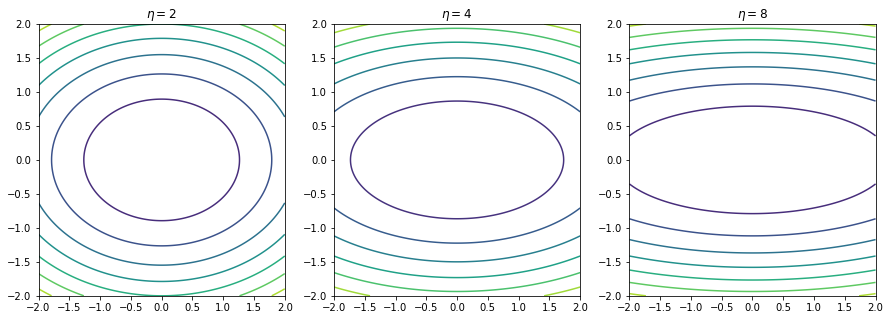

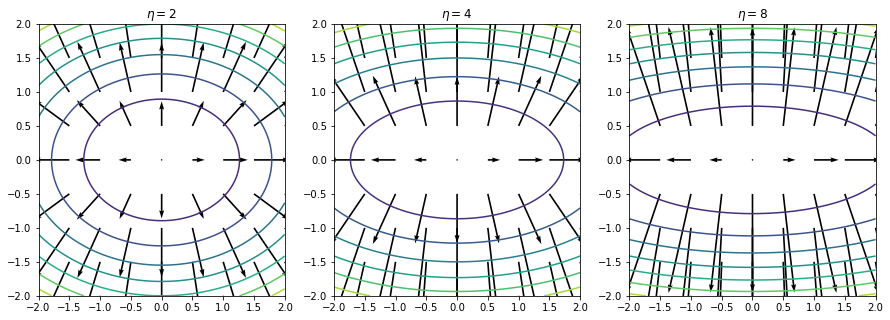

In [8]:
def q(x1,x2, eta):
    return 0.5*(x1**2 + eta*x2**2)


# Lignes de niveaux de q
tx1 = np.linspace(-2,2,200)
tx2 = np.linspace(-2,2,200)
gx1, gx2 = np.meshgrid(tx1,tx2)

plt.figure(figsize = (15,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    eta = 2*2**i
    Z = q(gx1,gx2,eta)
    plt.contour(gx1, gx2, Z)
    plt.title(u'$\eta = $'+str(eta))

# Champ de gradient
tx3 = np.linspace(-2,2,9)
gx3, gx4 = np.meshgrid(tx3,tx3)

plt.figure(figsize = (15,5))

for i in range(3):
    plt.subplot(1,3,i+1)
    eta = 2*2**i
    Z = q(gx1,gx2,eta)
    plt.contour(gx1, gx2, Z)
    plt.title(u'$\eta = $'+str(eta))    
    plt.quiver(gx3, gx4, gx3, eta*gx4, angles='xy', scale=10)

3. Pour chacune des $3$ valeurs de $\eta$ précédentes, représenter les $10$ premières itérations de la descente de gradient
$$
x^{(k+1)} = x^{(k)} - \tau \nabla q \left( x^{(k)} \right) \: .
$$
partant de et $x^{(0)} \in \{ (1.9,0.2), (1.9,1), (1.9,1.8) \}$.
On pourra prendre $\displaystyle 0 < \tau < \frac{2}{\eta}$, pourquoi ? Par exemple $\displaystyle \tau = \frac{1.6}{\eta}$.

La Hessienne $\nabla^2 q(x_1, x_2)$ de $q$ est constante par rapport à $(x_1, x_2)$ et sa plus grande valeur propre est $\eta \geq 1$. En reprenant le cours, on peut alors prendre un pas $\tau < \displaystyle \frac{2}{\eta}$ dans la méthode de gradient à pas fixe.

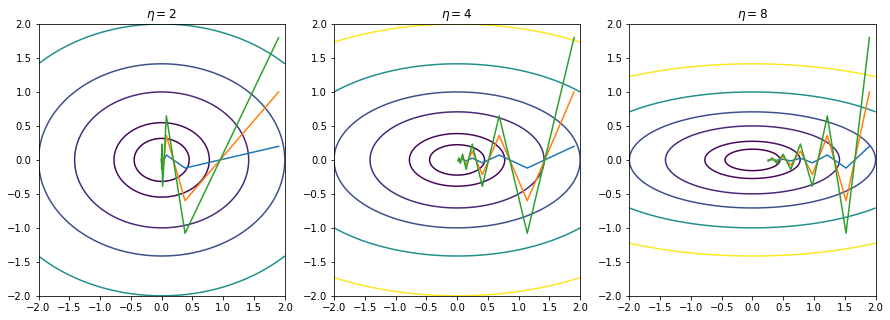

In [9]:
# gradient de q

def gradq(y,eta=4):
    return np.array([y[0], eta*y[1]])

nbIt = 10
xkarray = np.zeros((nbIt,2))

plt.figure(figsize = (15,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    eta = 2*2**i
    Z = q(gx1,gx2,eta)
    plt.contour(gx1, gx2, Z, [0.1, 0.3, 1, 2, 4, 8])
    plt.title(u'$\eta = $'+str(eta))
    
    tau = 1.6/eta
    for x0 in [np.array([1.9, 0.2]), np.array([1.9, 1]), np.array([1.9, 1.8])]:
        xkarray[0] = x0
        for k in range(nbIt-1):
            xk = xkarray[k]
            xkarray[k+1] = xk - tau*gradq(xk,eta)
        xk1 = xkarray[:,0] ; xk2 = xkarray[:,1]
        plt.plot(xk1, xk2)
        Z = q(gx1, gx2, eta)

4. Implémenter une fonction `gradDescent(gradfun, x0, nbIter, tau)` qui prendra en argument
- la fonction `gradfun` gradient de la fonction à minimiser, 
- `x0`$\in \mathbb{R}^N$ initialisation de la descente, 
- un entier `nbIter` qui sera le nombre d'itérations réalisées,
- `tau` le pas de descente.

Tester-là sur $q$ pour $\eta = 4$ par exemple.

In [10]:
# Voir question suivante

5. En faisant varier `nbIt`, vérifier qu'on retrouve bien une convergence de la forme
$$
\| x^{(k)} - x_\ast \| \leq C r^k 
$$
pour $C> 0$ et $0 < r < 1$ et estimer numériquement $r$ (dans le cas où $\eta = 4$ et $\displaystyle \tau = \frac{1.6}{\eta}$ par exemple). Est-ce en accord avec les notes de cours ?

Ici $x_\ast =(0,0)$ (unique minimiseur de $q$ sur $\mathbb{R}^2$, en passant au logarithme, on obtient
$$
\ln \| x^{(k)} - x_\ast \| \leq \ln C + k \ln r 
$$
En passant $\| x^{(k)} - x_\ast \|$ en échelle logarithmique, représenté en fonction de $k$, on obtient une allure de droite et en utilisant `np.polyfit` afin d'effectuer la régression linéaire, on trouve $a$ et $b$ tels que $\ln \| x^{(k)} - x_\ast \| \simeq b + a \: k$. Il reste à comparer ce $r = \exp(a)$ expérimental avec la borne théorique donnée par le cours :
$$
r_{theorique} \leq \max (| 1 - \tau l|, |1 - \tau L|)
$$
ici on peut prendre $l = 1$ et $L = \eta$ (ce sont les deux valeurs propres de la Hessienne de $q$ en tout point).

r = 0.6000000000000001
rtheorique = 0.6000000000000001  presque trop beau ...


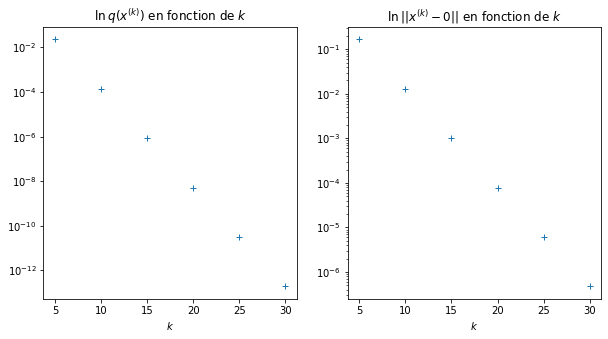

In [11]:
def gradDescent(gradfun, x0, nbIter, tau):
    xk = x0
    for k in range(nbIter):
        xk = xk - tau*gradfun(xk)
    return xk

eta = 4
tau = 1.6/eta
nbIterVect = 5*np.arange(1,7)
xfin = np.zeros((6,2))
for i,nbIter in enumerate(nbIterVect):
    xfin[i] = gradDescent(gradq, np.array([1.9, 1]), nbIter, tau)

ek = np.sqrt(xfin[:,0]**2 + xfin[:,1]**2)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.semilogy(nbIterVect, q(xfin[:,0], xfin[:,1], eta), '+')
plt.xlabel('$k$')
plt.title(u'$\ln \: q(x^{(k)})$ en fonction de $k$')
plt.subplot(1,2,2)
plt.semilogy(nbIterVect, ek, '+')
plt.xlabel('$k$')
plt.title(u'$\ln \: || x^{(k)} - 0 ||$ en fonction de $k$')

# Regression pour estimer r
xx = nbIterVect
yy = np.log(ek)
a,b = np.polyfit(xx, yy, 1)
r = np.exp(a)
print('r = '+str(r))

# Comparaison avec le taux théorique, l=1 et L=eta=4
rtheorique = np.max([np.abs(1-tau), np.abs(1-4*tau)])
print('rtheorique = '+str(rtheorique)+'  presque trop beau ...')
